# Hypothesis Testing

Section: b. Customers with children prefer online shopping

**Part of:** [marketing_campaign_082825_working.ipynb](./marketing_campaign_082825_working.ipynb)

In [1]:
# Setup and data loading
from utils import (
    ProjectConfig,
    load_intermediate_results,
    save_project_figure,
    reset_plot_settings,
)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

config = ProjectConfig()
# Load data from previous notebook
df = load_intermediate_results("data_from_08_step_6.pkl", config)


## b. Customers with children prefer online shopping

In [2]:
# b. Customers with children prefer online shopping

# Specify H₀ and H₁:
# H₀: The distributions of NumWebPurchases for customers with and without children are
#     identical (no difference in distribution).
# H₁: The distribution of NumWebPurchases for customers with children is stochastically
#     greater (they tend to have higher values).

# Normality and Test Choice:
# •  Use the t-test if NumWebPurchases is approximately normally distributed.
# •  Use the Mann-Whitney U test if the data is non-normal.

# Interpreting Results:
# •  P-value ≤ α (0.05): Reject H₀, concluding there is evidence that customers with children
#    prefer online shopping.
# •  P-value > α: Fail to reject H₀, indicating insufficient evidence that customers with children
#    prefer online shopping.

In [3]:
# Split data
df['Has_Children'] = df['Total_Children'] >= 1
web_with_children = df[df['Has_Children'] == 1]['NumWebPurchases']
web_without_children = df[df['Has_Children'] == 0]['NumWebPurchases']

In [4]:
# Normality check
from scipy.stats import shapiro

# Purpose:
# •  Tests the null hypothesis (H₀) that the data from the groups is normally distributed.
# •  Alternative hypothesis (H₁): The data is not normally distributed.

for group, data in [(1, web_with_children), (0, web_without_children)]:
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test for Has_Children = {group}: p-value = {p:.4f}")
    if p < 0.05:
        print("  p-value < 0.05: Reject H₀, data is not normally distributed.")
    else:
        print("  p-value >= 0.05: Fail to reject H₀, data may be normally distributed.")

Shapiro-Wilk Test for Has_Children = 1: p-value = 0.0000
  p-value < 0.05: Reject H₀, data is not normally distributed.
Shapiro-Wilk Test for Has_Children = 0: p-value = 0.0000
  p-value < 0.05: Reject H₀, data is not normally distributed.


Saved: figures\Box_and_Violin_Plots_Children_Customers.png


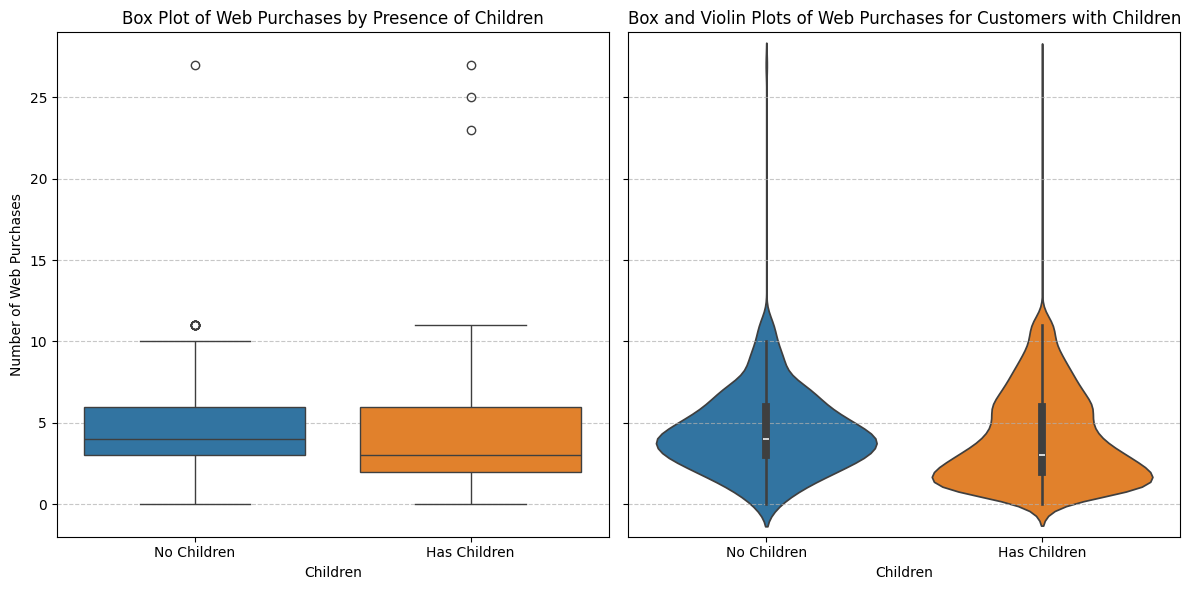


Descriptive Statistics
                  mean  median       std  count
Has_Children                                   
False         4.421801     4.0  2.468273    633
True          3.972431     3.0  2.879044   1596


In [5]:
# Create a figure with two subplots side by side

reset_plot_settings()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)

# Boxplot
sns.boxplot(x='Has_Children', y='NumWebPurchases', data=df, ax=ax1, hue='Has_Children', legend=False)
ax1.set_title("Box Plot of Web Purchases by Presence of Children")
ax1.set_ylabel("Number of Web Purchases")
ax1.set_xlabel('Children')
ax1.set_xticks([0,1], ['No Children', 'Has Children'])
ax1.set_ylim(-2,29)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Violin Plot
sns.violinplot(x='Has_Children', data=df, y='NumWebPurchases', legend=False, ax=ax2, hue='Has_Children')
ax2.set_title("Violin Plot of Web Purchases by Presence of Children")
ax2.set_xlabel('Children')
ax2.set_xticks([0,1], ['No Children', 'Has Children'])
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
save_project_figure(
    "Box_and_Violin_Plots_Children_Customers",
    "Box and Violin Plots of Web Purchases for Customers with Children",
    config,
)
plt.show()

# Descriptive Statistics
print("\nDescriptive Statistics")
dfstats = df.groupby('Has_Children')['NumWebPurchases'].agg(['mean','median','std','count'])
print(dfstats)

# Shapiro-Wilk test and plots show data is not normally distributed so a non-parametric
# test seems more appropriate

In [6]:
# Perform Mann-Whitney U Test (One-Tailed)
# H₀: The distributions of NumWebPurchases for customers with and without children are
#     identical (no difference in distribution).
# H₁: The distribution of NumWebPurchases for customers with children is greater
#     (they tend to have higher values).
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(web_with_children, web_without_children, alternative='greater')
print(f'Mann-Whitney U Test: statistic = {stat:.4f}, p-value = {p_value:.4f}')

# Interpretation
alpha = 0.05
if p_value <= alpha:
    print('Reject H₀: Customers with children have higher web puchases puchases')
else:
    print('Fail to reject H₀: No evidence that customers with children have higher web purchases')

Mann-Whitney U Test: statistic = 428511.0000, p-value = 1.0000
Fail to reject H₀: No evidence that customers with children have higher web purchases


In [7]:
# Why a t-test may be ok
# Large sample sizes (e.g., n > 30 or ideally n > 50 per group), due to the Central Limit Theorem (CLT).
# The CLT states that the sampling distribution of the mean approaches normality as sample size increases,
# even if the underlying data is non-normal.

print(f"Sample size for Has_Children:\n{df['Has_Children'].value_counts()}")
# Sample Size is Large: Both groups (HasChildren = 1 and 0) have n > 50
# the CLT helps ensure the t-test is robust.

Sample size for Has_Children:
Has_Children
True     1596
False     633
Name: count, dtype: int64


In [8]:
# Perform Levene's test

# Purpose:
# •  Tests the null hypothesis (H₀) that the variances of the groups are equal.
# •  Alternative hypothesis (H₁): The variances are not equal.

# Variations of test:
# •  Standard Levene’s Test: Uses the group mean for calculating deviations.
# •  Modified Levene’s Test (Brown-Forsythe): Uses the group median instead of the mean,
#    which is more robust to non-normal data.

# Implications of test:
# •  If Levene’s test indicates unequal variances (p-value ≤ 0.05), use Welch’s t-test to compare means.
# •  If variances are equal, use the standard t-test.

from scipy.stats import levene
alpha = 0.05

stat, p_levene = levene(web_with_children, web_without_children, center='median')
print(f"\nLevene's Test: statistic = {stat:.4f}, p-value = {p_levene:.4f}")
print(f"{'Unequal variances' if p_levene < alpha else 'Equal variances'} (p {'<' if p_levene < alpha else '>='} {alpha})")


Levene's Test: statistic = 22.7688, p-value = 0.0000
Unequal variances (p < 0.05)


In [9]:
# Unequal variances use Welch’s t-test to compare means
# Run parametric Welch's t-test

from scipy.stats import ttest_ind
print("\nWelch's t-Test (unequal variances):")
stat, p_welch = ttest_ind(web_with_children, web_without_children, alternative='greater', equal_var=False)
print(f"Welch's t-test: statistic = {stat:.4f}, p-value = {p_welch:.4f}")

if p_welch <= alpha:
    print('Reject H₀: Customers with children have higher web puchases puchases')
else:
    print('Fail to reject H₀: No evidence that customers with children have higher web purchases')


Welch's t-Test (unequal variances):
Welch's t-test: statistic = -3.6915, p-value = 0.9999
Fail to reject H₀: No evidence that customers with children have higher web purchases


In [10]:
# Conclusion
# Both the parametric test (Welch's t-Test) and the non-parametric test (Mann-Whitney U Test)
# fail to reject H₀, meaning there is no evidence that customers with children have higher web purchases

In [11]:

# Save results for next notebook
# save_intermediate_results(df_processed, 'processed_data.pkl', config)
# save_intermediate_results(analysis_results, 'analysis_results.pkl', config)
# print('✓ Results saved for next notebook')